In [201]:
import pandas as pd
pd.set_option('display.max_columns', None)
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt

In [202]:
df_cafe = pd.read_excel('asia_grill_2024_order01_cafe2.xlsx')
df_cafe

,#,duration,guest_count,check_amount,morning,lunch,evening,day_of_week,weekend,table,alcohol,cold_drink,complement,dessert,grill,hot_drink,main_course,other,salad,side_dish,soup,starter
0,3835,63.016667,1,585.0,1,0,0,Monday,0,д7 (Основний зал),0,0,1,1,0,1,1,0,0,0,0,0
1,3840,38.700000,1,377.0,0,0,1,Monday,0,д1 (Основний зал),1,0,0,0,0,0,0,0,0,1,0,0
2,3841,4.033333,1,198.0,0,0,1,Monday,0,д2 (Основний зал),0,0,0,0,1,0,0,0,0,0,0,0
3,3843,6.816667,1,15.0,1,0,0,Tuesday,0,Бар (Бар),0,0,0,0,0,0,0,1,0,0,0,0
4,3845,171.950000,1,1002.0,1,0,0,Tuesday,0,д7 (Основний зал),1,0,0,0,0,1,0,0,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4052,10625,42.100000,1,491.0,0,0,1,Monday,0,д3 (Основний зал),0,0,0,0,0,1,1,0,0,0,1,0
4053,10626,59.800000,3,629.0,0,0,1,Monday,0,д1 (Основний зал),0,0,0,1,0,1,1,0,0,0,0,0
4054,10628,66.183333,2,832.0,0,0,1,Monday,0,д4 (Основний зал),1,0,0,0,0,0,0,0,0,1,0,1
4055,10639,27.850000,1,470.0,1,0,0,Tuesday,0,д3 (Основний зал),0,0,0,0,0,0,0,0,0,0,1,0


In [203]:
def logit_backward_selection(X, y, pval_threshold=0.05):
    X = sm.add_constant(X, has_constant='add')
    excluded_vars = []
    
    while True:
        model = sm.Logit(y, X).fit(disp=False)
        pvalues = model.pvalues.drop('const', errors='ignore')
        
        max_pval = pvalues.max()
        if max_pval > pval_threshold:
            worst_var = pvalues.idxmax()
            excluded_vars.append((worst_var, max_pval))
            X = X.drop(columns=worst_var)
        else:
            break
    
    final_model = sm.Logit(y, X).fit(disp=False)
    return final_model, excluded_vars

In [204]:
main_effects = ['grill', 'salad', 'alcohol', 'starter', 'side_dish', 'cold_drink', 'guest_count', 'weekend', 'soup', 'lunch', 'evening', 'duration']

In [205]:
df_cafe['grill_salad'] = df_cafe['grill'] * df_cafe['salad']
df_cafe['alcohol_starter'] = df_cafe['alcohol'] * df_cafe['starter']
df_cafe['alcohol_side_dish'] = df_cafe['alcohol'] * df_cafe['side_dish']
df_cafe['guest_count_starter'] = df_cafe['guest_count'] * df_cafe['starter']
df_cafe['guest_count_side_dish'] = df_cafe['guest_count'] * df_cafe['side_dish']
df_cafe['weekend_starter'] = df_cafe['weekend'] * df_cafe['starter']
df_cafe['weekend_soup'] = df_cafe['weekend'] * df_cafe['soup']
df_cafe['lunch_soup'] = df_cafe['lunch'] * df_cafe['soup']
df_cafe['evening_soup'] = df_cafe['evening'] * df_cafe['soup']
df_cafe['grill_side_dish'] = df_cafe['grill'] * df_cafe['side_dish']
df_cafe['dessert_hot_drink'] = df_cafe['dessert'] * df_cafe['hot_drink']
df_cafe['duration_starter'] = df_cafe['duration'] * df_cafe['starter']
df_cafe['duration_side_dish'] = df_cafe['duration'] * df_cafe['side_dish']

In [206]:
features = main_effects + [
    'grill_salad', 'alcohol_starter', 'alcohol_side_dish',
    'guest_count_starter', 'guest_count_side_dish',
    'weekend_starter', 'weekend_soup',
    'duration_starter', 'duration_side_dish', 'lunch_soup', 'evening_soup', 'grill_side_dish', 'dessert_hot_drink'
]

In [207]:
main_model, main_removed = logit_backward_selection(df_cafe[features], df_cafe['main_course'])
print(main_model.summary())

                           Logit Regression Results                           
Dep. Variable:            main_course   No. Observations:                 4057
Model:                          Logit   Df Residuals:                     4046
Method:                           MLE   Df Model:                           10
Date:                Mon, 05 May 2025   Pseudo R-squ.:                  0.1083
Time:                        17:09:28   Log-Likelihood:                -2444.3
converged:                       True   LL-Null:                       -2741.1
Covariance Type:            nonrobust   LLR p-value:                4.411e-121
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -1.0442      0.089    -11.798      0.000      -1.218      -0.871
grill                    -0.6002      0.140     -4.285      0.000      -0.875      -0.326
salad   

In [208]:
print("Variables removed due to high p-value:")
for var, pval in main_removed:
    print(f"{var}: p = {pval:.4f}")

Variables removed due to high p-value:
guest_count_starter: p = 0.9971
duration: p = 0.9545
weekend_starter: p = 0.8919
dessert_hot_drink: p = 0.8865
side_dish: p = 0.7559
starter: p = 0.7223
weekend: p = 0.7113
duration_starter: p = 0.5993
soup: p = 0.5853
evening: p = 0.4912
alcohol_side_dish: p = 0.4446
lunch_soup: p = 0.4108
grill_side_dish: p = 0.3146
weekend_soup: p = 0.1553
duration_side_dish: p = 0.0902


In [209]:
features_new = ['grill', 'salad', 'alcohol', 'cold_drink', 'guest_count', 'lunch', 'grill_salad', 'alcohol_starter', 'guest_count_side_dish', 'evening_soup']

### ROC

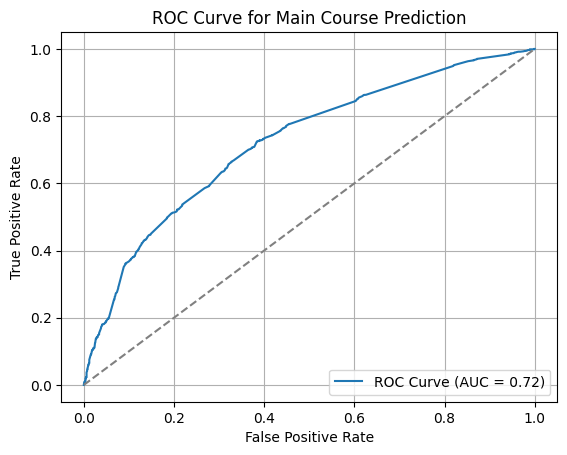

In [210]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# 1. Get predicted probabilities
X_new = sm.add_constant(df_cafe[features_new], has_constant='add')
y_pred_prob = main_model.predict(X_new)

# 2. Compute FPR, TPR for different thresholds
fpr, tpr, thresholds = roc_curve(df_cafe['main_course'], y_pred_prob)

# 3. Compute AUC score
roc_auc = roc_auc_score(df_cafe['main_course'], y_pred_prob)

# 4. Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Main Course Prediction')
plt.legend(loc='lower right')
plt.grid()
plt.show()

### VIF

In [211]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

X = df_cafe[features]
X = add_constant(X)

vif_df = pd.DataFrame()
vif_df["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_df["feature"] = X.columns
print(vif_df)

          VIF                feature
0   10.850455                  const
1    2.493291                  grill
2    1.651754                  salad
3    1.838080                alcohol
4    4.796567                starter
5    4.109502              side_dish
6    1.138406             cold_drink
7    3.270495            guest_count
8    2.007806                weekend
9    3.631646                   soup
10   2.328096                  lunch
11   2.356279                evening
12   1.824166               duration
13   2.858326            grill_salad
14   2.831708        alcohol_starter
15   2.550969      alcohol_side_dish
16   9.088245    guest_count_starter
17   8.186055  guest_count_side_dish
18   2.140448        weekend_starter
19   2.160653           weekend_soup
20   5.110578       duration_starter
21   5.011732     duration_side_dish
22   3.347375             lunch_soup
23   2.667524           evening_soup
24   2.765569        grill_side_dish
25   1.075438      dessert_hot_drink


### Sample size

In [212]:
outcome_counts = df_cafe['main_course'].value_counts(normalize=True)

least_freq_proba = outcome_counts.min()

num_predictors = len(features_new)

required_sample_size = int((10 * num_predictors) / least_freq_proba)

print(f"Least frequent class probability: {least_freq_proba:.3f}")
print(f"Number of predictors: {num_predictors}")
print(f"Required minimum sample size: {required_sample_size}")

Least frequent class probability: 0.407
Number of predictors: 10
Required minimum sample size: 245
